In [1]:
'''
GCBC with point maze
'''
from __future__ import print_function, division, unicode_literals
%load_ext autoreload
%autoreload 2
import math
import time
import os
import copy
import unicodedata
import string
import re
import random
from io import open

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch import distributions as pyd

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline
import seaborn as sns

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")
plt.ion()   # interactive mode - o

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# Define simple MLP
class MLP(nn.Module):
    def __init__(
        self, input_dim, hidden_dim, output_dim, hidden_depth, output_mod=None
    ):
        super().__init__()
        self.trunk = mlp(input_dim, hidden_dim, output_dim, hidden_depth, output_mod)
        self.apply(weight_init)

    def forward(self, x):
        return self.trunk(x)
    
def mlp(input_dim, hidden_dim, output_dim, hidden_depth, output_mod=None):
    if hidden_depth == 0:
        mods = [nn.Linear(input_dim, output_dim)]
    else:
        mods = [nn.Linear(input_dim, hidden_dim), nn.ReLU(inplace=True)]
        for i in range(hidden_depth - 1):
            mods += [nn.Linear(hidden_dim, hidden_dim), nn.ReLU(inplace=True)]
        mods.append(nn.Linear(hidden_dim, output_dim))
    if output_mod is not None:
        mods.append(output_mod)
    trunk = nn.Sequential(*mods)
    return trunk

# Custom weight init for Conv2D and Linear layers
def weight_init(m):
    if isinstance(m, nn.Linear):
        nn.init.orthogonal_(m.weight.data)
        if hasattr(m.bias, "data"):
            m.bias.data.fill_(0.0)

In [3]:
# Goal-conditioned Point Maze
import gym
import gym.wrappers

class PointEnvStandard(gym.Env):
    def __init__(self):
        self.pos = np.array([0., 0.])
        self.goal = np.array([-1., -1.])
        self.max_vel = 1
        self.observation_space = gym.spaces.Box(
            -np.inf * np.ones(4), np.inf * np.ones(4)
        )
        self.action_space = gym.spaces.Box(-np.ones(2), np.ones(2))
        self.action_space.seed(0)
        self.observation_space.seed(0)

    def reset(self):
        self.pos = np.zeros((2,))
        self.goal = np.ones((2,))
        return self.get_obs()

    def get_obs(self):
        return copy.deepcopy(np.concatenate([self.pos, self.goal])) # obs = current pos + goal state

    def step(self, action: np.ndarray):
        self.pos += self.max_vel*action
        reward = -np.linalg.norm((self.pos - self.goal))
        return self.get_obs(), reward, False, {}
    
    def reward_fn(self, state):
        return -torch.linalg.norm((state - torch.Tensor(self.goal).to(device)), dim=-1)
    
env1 = PointEnvStandard()

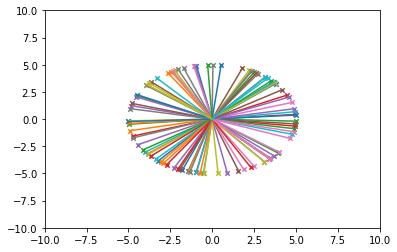

In [42]:
plt.xlim(-10, 10)
plt.ylim(-10, 10)
colors = sns.color_palette("hls", 10)

# Collect random rollouts from the environment, store it in some datasets
num_trajs = 100
train_trajs = []
angles = []

for tn in range(num_trajs):
    o = env1.reset().copy()
    #end_pos = np.random.uniform(-5, 5, size=(2,)) # Random ending point
    angle = np.random.uniform(0, 2*np.pi) # samples angle in radians
    end_pos = np.array([5*np.cos(angle), 5*np.sin(angle)])
    env1.goal = end_pos
    delta_vector = end_pos# - env1.pos # calculates distance to goal pos
    o = env1.get_obs()
    traj = {'obs': [],'action': [], 'next_obs': []}
    for i in range(100):
        ac = delta_vector * 0.01 # Go in direction between start and end
        no, r, d, _ = env1.step(ac)
        traj['obs'].append(o.copy())
        traj['action'].append(ac.copy())
        traj['next_obs'].append(no.copy())
        o = no.copy()
    traj['obs'] = np.array(traj['obs'])
    traj['action'] = np.array(traj['action'])
    traj['next_obs'] = np.array(traj['next_obs'])
    plt.plot(traj['obs'][:, 0], traj['obs'][:, 1]) # plots trajs + goals
    plt.scatter([end_pos[0]],[end_pos[1]], marker='x', s=20)
    train_trajs.append(traj)
    angle_curr = np.arctan2(traj['obs'][-1, 0], traj['obs'][-1, 1])
    angles.append(angle_curr.copy())

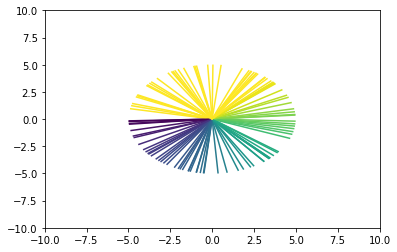

In [43]:
# double checking the angles are calculated + stored correctly
f, ax = plt.subplots()
ax.set_xlim(-10, 10)
ax.set_ylim(-10, 10)
from matplotlib import cm
angles = []

for t in train_trajs:
    angle = np.arctan2(t['obs'][-1, 1], t['obs'][-1, 0]) + np.pi
    angles.append(angle)
    ax.plot(t['obs'][:, 0], t['obs'][:, 1], c=cm.viridis(angle/4))

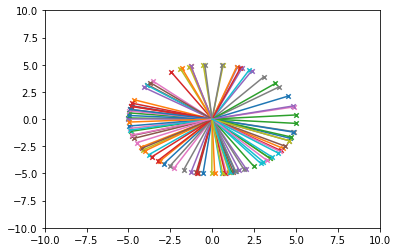

In [19]:
plt.xlim(-10, 10)
plt.ylim(-10, 10)
colors = sns.color_palette("hls", 10)

# generate training trajectories from same starting location (0.,0.) -> different random end location
num_trajs = 100
test_trajs = []
angles = []

#start_pos = np.random.uniform(-5, 5, size=(2,)) # Random starting point
for tn in range(num_trajs):
    o = env1.reset().copy()
    #end_pos = np.random.uniform(-5, 5, size=(2,)) # Random ending point
    angle = np.random.uniform(0, 2*np.pi) # samples angle in radians
    end_pos = np.array([5*np.cos(angle), 5*np.sin(angle)])
    env1.goal = end_pos
    delta_vector = end_pos# - env1.pos # calculates distance to goal pos
    o = env1.get_obs()
    traj = {'obs': [],'action': [], 'next_obs': []}
    for i in range(100):
        ac = delta_vector * 0.01 # Go in direction between start and end
        no, r, d, _ = env1.step(ac)
        traj['obs'].append(o.copy())
        traj['action'].append(ac.copy())
        traj['next_obs'].append(no.copy())
        o = no
    traj['obs'] = np.array(traj['obs'])
    traj['action'] = np.array(traj['action'])
    traj['next_obs'] = np.array(traj['next_obs'])
    plt.plot(traj['obs'][:, 0], traj['obs'][:, 1]) # plots trajs + goals
    plt.scatter([end_pos[0]],[end_pos[1]], marker='x', s=20)
    test_trajs.append(traj)
    angle_curr = np.arctan2(traj['obs'][-1, 0], traj['obs'][-1, 1])
    angles.append(angle_curr.copy())

In [44]:
# Define the forward model
class Policy(nn.Module):
    def __init__(self, obs_dim, action_dim, hidden_dim, hidden_depth):
        super().__init__()
        self.trunk = mlp(obs_dim, hidden_dim, action_dim, hidden_depth)
        self.outputs = dict()
        self.apply(weight_init)

    def forward(self, obs):
        next_pred = self.trunk(obs)
        return next_pred

In [45]:
hidden_layer_size = 1000
hidden_depth = 3
horizon = 100
obs_size = env1.observation_space.shape[0]
ac_size = env1.action_space.shape[0]
policy = Policy(obs_size, ac_size, hidden_layer_size, hidden_depth)
num_tasks = len(train_trajs)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
policy.to(device)

Policy(
  (trunk): Sequential(
    (0): Linear(in_features=4, out_features=1000, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=1000, out_features=1000, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=1000, out_features=1000, bias=True)
    (5): ReLU(inplace=True)
    (6): Linear(in_features=1000, out_features=2, bias=True)
  )
)

[1,     1] loss: 0.00438303
[2,     1] loss: 0.04535275
[3,     1] loss: 0.01526675
[4,     1] loss: 0.00836258
[5,     1] loss: 0.00464785
[6,     1] loss: 0.00379797
[7,     1] loss: 0.00261533
[8,     1] loss: 0.00213347
[9,     1] loss: 0.00220297
[10,     1] loss: 0.00170845
[11,     1] loss: 0.00129245
[12,     1] loss: 0.00111127
[13,     1] loss: 0.00111150
[14,     1] loss: 0.00061688
[15,     1] loss: 0.00102726
[16,     1] loss: 0.00068362
[17,     1] loss: 0.00085994
[18,     1] loss: 0.00034182
[19,     1] loss: 0.00067492
[20,     1] loss: 0.00063083
[21,     1] loss: 0.00040401
[22,     1] loss: 0.00048119
[23,     1] loss: 0.00039154
[24,     1] loss: 0.00026108
[25,     1] loss: 0.00037932
[26,     1] loss: 0.00022634
[27,     1] loss: 0.00026947
[28,     1] loss: 0.00025505
[29,     1] loss: 0.00029107
[30,     1] loss: 0.00036930
[31,     1] loss: 0.00050680
[32,     1] loss: 0.00034093
[33,     1] loss: 0.00030342
[34,     1] loss: 0.00035886
[35,     1] loss: 0.000

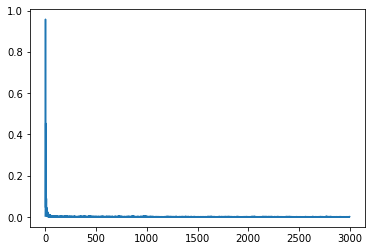

In [46]:
num_epochs = 1000
batch_size = 50

criterion = nn.MSELoss()
optimizer = optim.Adam(list(policy.parameters()))

losses = []

idxs = np.array(range(len(train_trajs)))

num_batches = len(idxs) // batch_size
# Train the model with regular SGD
for epoch in range(num_epochs):  # loop over the dataset multiple times
    np.random.shuffle(idxs)
    running_loss = 0.0
    for i in range(num_batches):
        optimizer.zero_grad()

        t1_idx = np.random.randint(len(train_trajs), size=(batch_size,)) # Indices of traj
        t1_idx_pertraj = np.random.randint(100, size=(batch_size,))
        t1_states = np.concatenate([train_trajs[c_idx]['obs'][t_idx][None] for (c_idx, t_idx) in zip(t1_idx, t1_idx_pertraj)])
        t1_actions = np.concatenate([train_trajs[c_idx]['action'][t_idx][None] for (c_idx, t_idx) in zip(t1_idx, t1_idx_pertraj)])
   
        t1_states = torch.Tensor(t1_states).float().to(device)
        t1_actions = torch.Tensor(t1_actions).float().to(device)
        
        a1_pred = policy(t1_states.to(device)) # action prediction
        
        loss = torch.mean(torch.linalg.norm(a1_pred - t1_actions, dim=-1)) # supervised learning loss
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 100 == 0:
            print('[%d, %5d] loss: %.8f' %
                  (epoch + 1, i + 1, running_loss / 10.))
            losses.append(running_loss/10.)
            running_loss = 0.0
        losses.append(loss.item())

print('Finished Training')
plt.plot(losses)

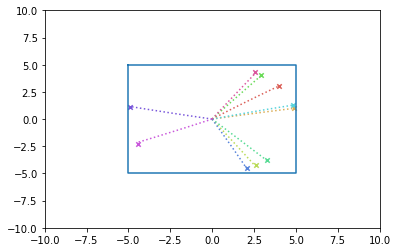

In [51]:
plt.xlim(-10, 10)
plt.ylim(-10, 10)
colors = sns.color_palette("hls", 10)

num_test_trajs = 10

for k in range(num_test_trajs):
    o = env1.reset()
    angle = np.random.uniform(0, 2*np.pi) # samples angle in radians
    end_pos = np.array([5*np.cos(angle), 5*np.sin(angle)])
    env1.goal = end_pos
    o = env1.get_obs()
    
    traj = {'obs': [],'action': [], 'next_obs': []}
    for i in range(100):
        t1s = torch.Tensor(o[None]).to(device)
        ac = policy(t1s).cpu().detach().numpy()[0]
        no, r, d, _ = env1.step(ac)
        traj['obs'].append(o.copy())
        traj['action'].append(ac.copy())
        traj['next_obs'].append(no.copy())
        o = no.copy()
    plt.plot(np.array(traj['obs'])[:, 0], np.array(traj['obs'])[:, 1], linestyle=':', color=colors[k])
    plt.scatter([end_pos[0]],[end_pos[1]], color=colors[k], marker='x', s=20)
    
plt.plot([-5, 5, 5, -5, -5], [5, 5,-5, -5, 5])